In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as r
import scipy.stats as s

In [27]:
def generate_gaussian_data(dim=2, size=100):
    means = np.concatenate(([-2, -2], [0, 0], [2, 2])).reshape(3, dim)
    covs = r.rand(3, dim, dim)
    
    return np.concatenate([r.multivariate_normal(means[i, :], covs[i, ...], size) for i in range(3)]), means, covs

In [28]:
def plot_data(data):
    fig, ax = plt.subplots(1)
    ax.scatter(data[:100, 0], data[:100, 1], c='red')
    ax.scatter(data[100:200, 0], data[100:200, 1], c='green')
    ax.scatter(data[200:300, 0], data[200:300, 1], c='blue')
    return fig, ax

In [29]:
class gmm_cluster:
    
    def __init__(self, phi, mu, sigma):
        self.phi = phi
        self.mu = mu
        self.sigma = sigma
        self.w = None
        
    def __str__(self):
        return "Phi: %s | Mu: %s | Sigma: %s " % (str(self.phi), str(self.mu), str(self.sigma))
    
    def __repr__(self):
        return self.__str__()

In [30]:
def init_gmm_clusters(random_distr, data, K=3):
    N = len(data)
    D = data.shape[1]
    if random_distr:
        phi = r.dirichlet(np.ones(K), 1).reshape(K,).astype(np.float128)
    else:
        phi = np.full(K, 1/K, dtype=np.float128)
    
    idx = r.choice(N, K, replace=True)
    mu = list()
    for i in idx:
        mu.append(data[i])
    mu = np.array(mu)
    
    return [gmm_cluster(phi[k], mu[k], np.identity(D, dtype=np.float128)) for k in range(K)]

In [31]:
def e_step(data, clusters):
    N = len(data)
    K = len(clusters)
    # guess the probabilities of each x_i coming from cluster k
    # guess p(z_k = 1 | x_i ; phi_k, mu_k, sigma_k)
    denom = np.zeros((N, ), dtype=np.float128)
    for c in clusters:
        
        N = s.multivariate_normal(c.mu, c.sigma)
        nom = (c.phi * N.pdf(data)).astype(np.float128)
        denom += nom
        
        c.w = nom
    
    for c in clusters:
        c.w /= denom

In [32]:
def multi(w, v):
    assert len(w) == len(v)
    r = np.zeros_like(v)
    
    for i in range(len(w)):
        r[i] = w[i] * v[i]
        
    assert r.shape == v.shape
    return r
    

In [33]:
def m_step(data, clusters):
    N = len(data)
    K = len(clusters)
    for c in clusters:
        
        c.phi = np.mean(c.w)
        
        c.mu = np.dot(c.w.T, data) / np.sum(c.w)
        
        diff = (data - c.mu)
        c.sigma = np.dot(multi(c.w, diff).T, diff) / np.sum(c.w)

In [34]:
def p_x_zj(x, mu_j, sigma_j):
    N = s.multivariate_normal(mu_j, sigma_j)
    return N.pdf(x);

def p_zj(phi_j):
    return phi_j

In [35]:
def likelihood(data, clusters):
    l = 0
    #for c in clusters:
    #    p = np.sum(p_x_zj(data, c.mu, c.sigma) * p_zj(c.phi))
    #    l += np.log(p)
    
    for xi in data:
        p = np.sum([p_x_zj(xi, c.mu, c.sigma) * p_zj(c.phi) for c in clusters])
        l += np.log(p)
    
    return l

In [36]:
def gmm(data, k=3, eps=0.001, verbose = True):
    clusters = init_gmm_clusters(True, data, k)
    l = list()
    l.append(10 * 100)
    
    for i in range(10000):
        e_step(data, clusters)
        m_step(data, clusters)
        l.append(likelihood(data, clusters))
        print('Epoch: %i, Likelihood: %.20f' % (i, l[i]))
        if np.abs(l[i-1] - l[i]) <= eps:
            print('GMM converged!')
            break;
        
    return clusters, l

In [37]:
def classify(data, clusters):
    N = len(data)
    K = len(clusters)
    pred = np.zeros((N, K))
    
    for k, c in enumerate(clusters):
        pred[:, k] = c.w
    
    return pred

In [38]:
def get_color_labels(pred, colors=('m', 'y', 'c')):
    assert pred.shape == (300, 3)
    argmax = np.argmax(pred, axis=1)
    labels = list()
    for amx in argmax:
        labels.append(colors[amx])
        
    return np.array(labels).reshape(300, )

In [39]:
def evaluate(pred, data):
    fig, axs = plt.subplots(1, 2)
    axs[0].set(title='GMM clusters')
    axs[1].set(title='Labels')
    # labels
    axs[1].scatter(data[:100, 0], data[:100, 1], c='red')
    axs[1].scatter(data[100:200, 0], data[100:200, 1], c='green')
    axs[1].scatter(data[200:300, 0], data[200:300, 1], c='blue')
    
    # prediction
    colors = get_color_labels(pred)
    axs[0].scatter(data[:, 0], data[:, 1], s=80, facecolors='none', edgecolors=colors)

means [[-2 -2]
 [ 0  0]
 [ 2  2]]
sigmas [[[0.17469765 0.66551677]
  [0.47888327 0.72910767]]

 [[0.39959492 0.43382484]
  [0.68072252 0.36495781]]

 [[0.17371089 0.33020753]
  [0.96190678 0.20638108]]]


/home/p0w3r/bin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff78cd3cf60>)

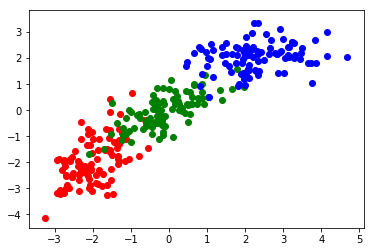

In [52]:
data, means, sigmas = generate_gaussian_data()
print('means', means)
print('sigmas', sigmas)
plot_data(data)

Epoch: 0, Likelihood: 1000.00000000000000000000
Epoch: 1, Likelihood: -882.94247549402780350647
Epoch: 2, Likelihood: -880.26916279869976733607
Epoch: 3, Likelihood: -877.59834235338996677456
Epoch: 4, Likelihood: -874.76907033074064656830
Epoch: 5, Likelihood: -872.20613532467859840835
Epoch: 6, Likelihood: -870.33782890101406337635
Epoch: 7, Likelihood: -869.23542299818677747680
Epoch: 8, Likelihood: -868.67086205032831003336
Epoch: 9, Likelihood: -868.38339061613737612788
Epoch: 10, Likelihood: -868.21018973845866639749
Epoch: 11, Likelihood: -868.07526631069629274862
Epoch: 12, Likelihood: -867.94761750061206839746
Epoch: 13, Likelihood: -867.81434865365463338094
Epoch: 14, Likelihood: -867.66878001795134878193
Epoch: 15, Likelihood: -867.50604282415179113741
Epoch: 16, Likelihood: -867.32168103015828819480
Epoch: 17, Likelihood: -867.11146091800253543624
Epoch: 18, Likelihood: -866.87183788960248875810
Epoch: 19, Likelihood: -866.60096863379521892057
Epoch: 20, Likelihood: -866.30

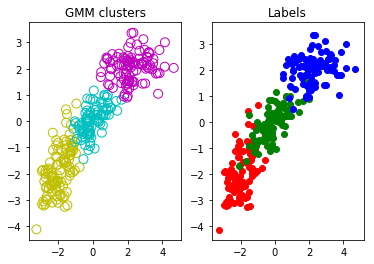

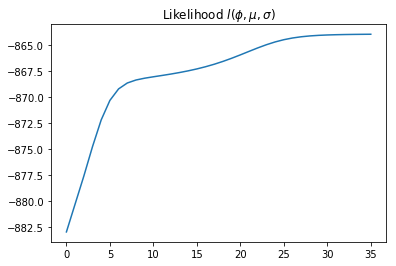

In [53]:
clusters, likelihoods = gmm(data, eps=0.01)
pred = classify(data, clusters)
evaluate(pred, data)

for c in clusters:
    print(c)

fig, ax = plt.subplots(1)
ax.set(title=r'Likelihood $l(\phi, \mu, \sigma)$')
ax.plot(likelihoods[1:])

In [54]:
class km_cluster:
    
    def __init__(self, centroid, color):
        assert centroid.shape == (2, )
        self.centroid = centroid
        self.data_points = np.array([0, 0])
        self.color = color
    
    def add_data_point(self, x):
        assert x.shape == (2, )
        if len(self.data_points) == 1: # override initial data_point
            self.data_points[0] = x
        else:    
            self.data_points = np.vstack((self.data_points, x))
        
    def update_centroid(self):
        self.centroid = np.mean(self.data_points, axis=0)
        assert self.centroid.shape == (2, )
        
    def calc_distance(self, x):
        return np.linalg.norm(x - self.centroid)
    
    def clear(self):
        self.data_points =  np.array([0, 0])
        
    def plot(self, ax = None):
        if ax == None:
            fig, ax = plt.subplots(1)
        
        ax.scatter(self.data_points[:, 0], self.data_points[:, 1], s=80, facecolors='none', edgecolors=self.color)
        return ax
    
    def __str__(self):
        return "Centroid: %s" % (str(self.centroid))

def init_clusters(data, k):
    idx = r.choice(300, k, replace=True)
    clusters = list()
    colors = ['m', 'y', 'c']
    for i in range(k):
        clusters.append(km_cluster(data[idx[i]], colors[i]))

    return clusters

In [57]:
def kmeans(data, k=3, N=10):
    clusters = init_clusters(data, k)
    
    for i in range(N):
    # clear the data points of the clusters        
        for c in clusters:
            c.clear()
    # find the closest cluster for each data point
        for x_i in data:
            distances = list()
            # compute l2 norm of distance from each of the k  cluster centroids to each data point 
            for c in clusters:
                distances.append(c.calc_distance(x_i))
            # add x_i to the cluster with the minimum distance
            clusters[np.argmin(distances)].add_data_point(x_i)
    # set the new cluster centroids to the mean of the data points assigned cluster
        for c in clusters:
            c.update_centroid()
    
    return clusters

Centroid: [2.27271822 2.0261508 ]
Centroid: [-1.93579551 -1.92003393]
Centroid: [-0.06199018  0.09040654]


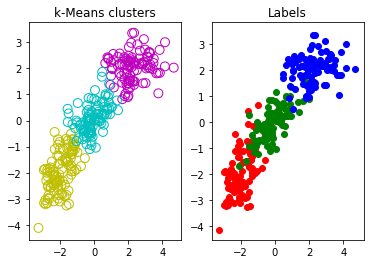

In [58]:
clusters = kmeans(data, 3, 5)

fig, axs = plt.subplots(1, 2)
axs[0].set(title='k-Means clusters')
axs[1].set(title='Labels')
# labels
axs[1].scatter(data[:100, 0], data[:100, 1], c='red')
axs[1].scatter(data[100:200, 0], data[100:200, 1], c='green')
axs[1].scatter(data[200:300, 0], data[200:300, 1], c='blue')

for c in clusters:
    c.plot(axs[0])
    print(c)